import libraries and read data

In [1]:
!pip uninstall eodal -y
!pip install git+https://github.com/lukasValentin/eodal.git@landsat-dev

Found existing installation: eodal 0.2.1
Uninstalling eodal-0.2.1:
  Successfully uninstalled eodal-0.2.1
  Cloning https://github.com/lukasValentin/eodal.git (to revision landsat-dev) to c:\users\finnt\appdata\local\temp\pip-req-build-wpqd4y65
  Resolved https://github.com/lukasValentin/eodal.git to commit 8b2fce3ddcf95ab6c76a8b928bd5534f57569548
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for eodal: filename=eodal-0.2.1-py3-none-any.whl size=190148 sha256=a01ea9664f48cf3f58083fa7348bdc9456631031e6cc9531f9dc0cdf711243ef
  Stored in directory: C:\Users\finnt\AppData\Local\Temp\pip-ephem-wheel-cache-l9jsc_zy\wheels\7f\a8\ca\6f055189509d8e9374288b56f7b03008dc5d8432456f8b8e9a
Successfully bui

  Running command git clone --filter=blob:none --quiet https://github.com/lukasValentin/eodal.git 'C:\Users\finnt\AppData\Local\Temp\pip-req-build-wpqd4y65'
  Running command git checkout -b landsat-dev --track origin/landsat-dev
  branch 'landsat-dev' set up to track 'origin/landsat-dev'.
  Switched to a new branch 'landsat-dev'


In [2]:
#import what is needed
from datetime import datetime
from pathlib import Path
from shapely.geometry import box

from eodal.config import get_settings
from eodal.core.sensors import Landsat
from eodal.core.scene import SceneCollection
from eodal.mapper.feature import Feature

In [3]:
# read data from pickled file object into SceneCollectio
fpath = Path('Y:\MSc_23_TimckeFinn\data\EOdal\sample_mapper_data.pkl')
scoll = SceneCollection.from_pickle(stream=fpath)
scoll

EOdal SceneCollection
----------------------
# Scenes:    1
Timestamps:    2023-05-14 00:00:00
Scene Identifiers:    LC09_L2SP_173060_20230514_20230517_02_T1

delete no data

C:\Users\finnt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


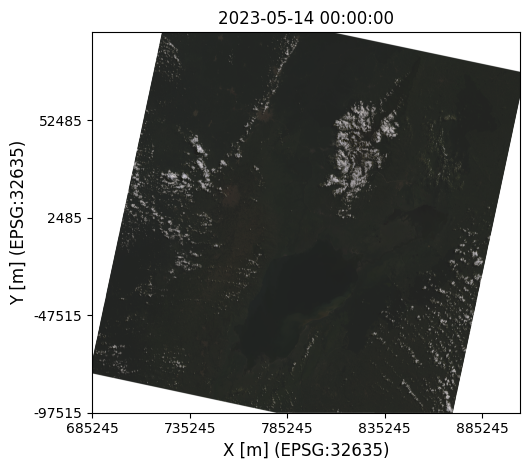

In [7]:
%matplotlib inline  

# the scenes can be plotted
f_scenes = scoll.plot(['red', 'green', 'blue'])

In [5]:
# loop over available scenes stored in scoll as a EOdal SceneCollection and check
# for no-data. These scenes will be removed from the SceneCollection
scenes_to_del = []
scoll.metadata['scene_used'] = 'yes'

for scene_id, scene in scoll:

    # check if scene is blackfilled (nodata); if yes continue
    if scene.is_blackfilled:
        scenes_to_del.append(scene_id)
        mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
        continue

    # check cloud coverage (including shadows and snow) of the field parcel
    feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

    # if the scene is too cloudy, we skip it
    if feature_cloud_cover > feature_cloud_cover_threshold:
        scenes_to_del.append(scene_id)
        mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
        continue

    # calculate the NDVI and MSAVI
    scene.calc_si('NDVI', inplace=True)
    scene.calc_si('MSAVI', inplace=True)

# delete scenes too cloudy or containing only no-data
for scene_id in scenes_to_del:
    del mapper.data[scene_id]

AttributeError: 'SceneCollection' object has no attribute 'metadata'

Get values

In [11]:
import numpy as np

# Specify the fill value
fill_value = 0

# Create a masked array
for scene_id, scene in scoll:
   
   masked_array = scene.get_values()

   # Convert masked array to a normal NumPy array with fill value
   normal_array = masked_array.filled(fill_value)

   # Convert NumPy array to Pandas DataFrame
   df = pd.DataFrame(normal_array)

print(df)

MemoryError: Unable to allocate 4.25 GiB for an array with shape (12, 6501, 7308) and data type float64